In [1]:
import pandas as pd
import numpy as np
import yaml

import joblib

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.stats import chi2_contingency

from itertools import product
from textwrap import fill

from sklearn.model_selection import train_test_split


In [2]:
PATH_CONFIG = '../config/config.yaml'
config = yaml.safe_load(open(PATH_CONFIG))

In [4]:
# import dataset
file_name = '../' + config['data_source']['directory'] + config['data_source']['file_name']
dataset = pd.read_csv(file_name)

Dataset source: <br>
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4954928053318020/1058911316420443/167703932442645/latest.html

**Train-test split**

In [5]:
# split features and label
target = config['data_source']['target_name']

X = dataset.drop(target, axis = 1)
y = dataset[target]

In [6]:
# split train and test data
test_size = config['data_source']['test_size']
random_state = config['data_source']['random_state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state, stratify = y)

In [7]:
print(f'Shape of train data features: {X_train.shape}')
print(f'Shape of train data label: {y_train.shape}')

Shape of train data features: (700, 38)
Shape of train data label: (700,)


In [8]:
print(f'Ratio train label: {y_train.value_counts(normalize=True)}')

Ratio train label: fraud_reported
N    0.752857
Y    0.247143
Name: proportion, dtype: float64


In [9]:
print(f'Shape of test data features: {X_test.shape}')
print(f'Shape of test data label: {y_test.shape}')

Shape of test data features: (300, 38)
Shape of test data label: (300,)


In [10]:
print(f'Ratio test label: {y_test.value_counts(normalize=True)}')

Ratio test label: fraud_reported
N    0.753333
Y    0.246667
Name: proportion, dtype: float64


In [12]:
# store train and test dataset
X_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train']
y_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train']
X_test_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_test']
y_test_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_test']

joblib.dump(X_train, X_train_path)
joblib.dump(y_train, y_train_path)
joblib.dump(X_test, X_test_path)
joblib.dump(y_test, y_test_path)

['../data/processed/y_test.pkl']

**EXPLORATORY DATA ANALYSIS**

In [14]:
train_dataset = pd.concat([X_train, y_train], axis = 1)

In [15]:
pd.set_option('display.max_columns', 500)
train_dataset.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
889,191,38,753005,2005-11-20 00:00:00,IL,100/300,2000,1253.44,0,608525,FEMALE,Masters,craft-repair,sleeping,not-in-family,0,0,2015-02-07 00:00:00,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,VA,Hillsdale,7201 Washington Ave,19,3,NO,2,0,NO,56320,10240,5120,40960,Volkswagen,Jetta,2007,N
692,137,35,153027,2010-03-11 00:00:00,IN,250/500,500,1667.83,0,460586,MALE,JD,prof-specialty,paintball,husband,48500,-67400,2015-02-04 00:00:00,Parked Car,?,Minor Damage,Police,WV,Northbrook,4447 Francis Hwy,4,1,YES,1,1,NO,6600,1200,1200,4200,Jeep,Grand Cherokee,2005,N
621,87,27,326289,2004-01-03 00:00:00,OH,100/300,500,1048.39,0,620962,FEMALE,Masters,transport-moving,polo,own-child,0,0,2015-02-13 00:00:00,Single Vehicle Collision,Side Collision,Minor Damage,Police,NY,Riverwood,6608 Apache Lane,2,1,?,2,1,YES,34650,6300,3150,25200,Ford,F150,1996,N
355,256,43,883980,2014-12-13 00:00:00,OH,100/300,500,1203.17,0,455810,FEMALE,MD,prof-specialty,golf,unmarried,56700,-65600,2015-02-06 00:00:00,Single Vehicle Collision,Rear Collision,Total Loss,Fire,WV,Hillsdale,8834 Elm Drive,11,1,NO,0,0,?,63250,11500,5750,46000,Nissan,Ultima,1997,N
362,150,30,354481,2004-11-17 00:00:00,IN,100/300,1000,1342.02,0,608425,MALE,MD,prof-specialty,polo,own-child,0,0,2015-02-28 00:00:00,Parked Car,?,Trivial Damage,NaN,VA,Arlington,6317 Best St,8,1,YES,0,2,NO,4500,450,450,3600,Saab,93,1999,N


Because the model will not be dealing with time series, so some features related to time will be dropped later. And for the location features like incident_location and incident_city have been represented by incident_state, those two feature will be dropped too. So do for the other irrelevant features like policy_number and insured_zip. 

In [16]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 889 to 395
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           700 non-null    int64  
 1   age                          700 non-null    int64  
 2   policy_number                700 non-null    int64  
 3   policy_bind_date             700 non-null    object 
 4   policy_state                 700 non-null    object 
 5   policy_csl                   700 non-null    object 
 6   policy_deductable            700 non-null    int64  
 7   policy_annual_premium        700 non-null    float64
 8   umbrella_limit               700 non-null    int64  
 9   insured_zip                  700 non-null    int64  
 10  insured_sex                  700 non-null    object 
 11  insured_education_level      700 non-null    object 
 12  insured_occupation           700 non-null    object 
 13  insured_hobbies        

In [17]:
datetime_features = config['data_source']['datetime_features']
cat_features = config['data_source']['cat_features']
num_int_features = config['data_source']['num_int_features']
num_float_features = config['data_source']['num_float_features']
num_features = config['data_source']['num_features']

In [18]:
# fixing all columns with the suitable data type
train_dataset[datetime_features] = pd.to_datetime(train_dataset[datetime_features].stack()).unstack()
train_dataset[cat_features] = train_dataset[cat_features].astype(object)
train_dataset[num_int_features] = train_dataset[num_int_features].astype(int)
train_dataset[num_float_features] = train_dataset[num_float_features].astype(float)

Sanity check data type

In [19]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 889 to 395
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           700 non-null    int64         
 1   age                          700 non-null    int64         
 2   policy_number                700 non-null    object        
 3   policy_bind_date             700 non-null    datetime64[ns]
 4   policy_state                 700 non-null    object        
 5   policy_csl                   700 non-null    object        
 6   policy_deductable            700 non-null    float64       
 7   policy_annual_premium        700 non-null    float64       
 8   umbrella_limit               700 non-null    float64       
 9   insured_zip                  700 non-null    object        
 10  insured_sex                  700 non-null    object        
 11  insured_education_level      700 non-null    obj

Checking is there any inconsistent or strange character in the data

In [20]:
for col in train_dataset[cat_features]:
    print(f'{col}:')
    print(train_dataset[col].unique())
    print('')

policy_number:
[753005 153027 326289 883980 354481 221854 884180 920826 399524 836272
 419510 500384 608443 604614 762951 687755 505014 893853 830878 600845
 129872 658002 999435 426708 941851 717392 326322 413192 219028 380067
 175553 172307 589094 942504 414519 740384 790442 524215 950542 411477
 149467 520179 476923 904191 565157 605100 337677 781181 497929 119513
 918037 276804 507452 216738 749325 351741 379268 527945 903785 148498
 890280 336047 573572 298412 769475 981123 664732 735822 369226 674570
 907012 278091 217938 435784 376879 726880 266247 593466 718829 556415
 155604 343161 638155 743092 550294 669501 477177 121439 729634 241562
 218684 134430 720356 212580 509489 442494 991480 865839 842643 237418
 156694 200152 901083 960680 509928 623648 431583 998192 844062 944102
 634499 932097 149367 938634 552618 674485 259792 287436 552788 283414
 312940 307195 743330 467841 710741 514065 331170 135400 403776 908935
 352120 267885 431478 976645 679370 940942 843227 729534 37373

Turns out there is a strange character '?' in the data. Suppose it means null value.

In [21]:
train_dataset = train_dataset.replace({'?': None})

Check missing value

In [22]:
print('Numerical columns:')
print(train_dataset[num_features].isna().sum())
print('-' * 40)
print('Categorical columns:')
print(train_dataset[cat_features].isna().sum())


Numerical columns:
months_as_customer             0
age                            0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
bodily_injuries                0
witnesses                      0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
capital-gains                  0
capital-loss                   0
total_claim_amount             0
injury_claim                   0
property_claim                 0
vehicle_claim                  0
dtype: int64
----------------------------------------
Categorical columns:
policy_number                0
policy_state                 0
policy_csl                   0
insured_zip                  0
insured_sex                  0
insured_education_level      0
insured_occupation           0
insured_hobbies              0
insured_relationship         0
incident_type                0
collision_type             126
incident_severity            0
authorities_contacted       64
incident

In the numerical columns, there is no missing value. Meanwhile in the categorical columns, there is missing values in some features. To handle this problem, do imputation for those with 'UNKNOWN' value.

In [23]:
train_dataset[cat_features] = train_dataset[cat_features].fillna('UNKNOWN')

In [24]:
# re-check missing value
train_dataset.isna().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

Check duplicated data

In [25]:
train_dataset.duplicated().sum()

0

There is no duplicated data.

**Univariate Analysis**

***Numerical data***

Check outlier

In [26]:
pd.set_option('float_format', '{:,.2f}'.format)
train_dataset[num_features].describe()

,months_as_customer,age,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,total_claim_amount,injury_claim,property_claim,vehicle_claim
count,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00,700.00
mean,202.55,38.90,11.41,1.81,0.98,1.50,"1,130.00","1,260.30","1,124,285.71","24,957.00","-27,030.00","52,344.07","7,401.10","7,359.70","37,583.27"
std,116.24,9.17,6.95,1.01,0.83,1.11,612.42,243.54,"2,332,879.73","27,689.23","28,346.00","26,418.66","4,887.33","4,861.41","18,907.68"
min,1.00,19.00,0.00,1.00,0.00,0.00,500.00,433.33,0.00,0.00,"-111,100.00",100.00,0.00,0.00,70.00
25%,111.00,32.00,5.00,1.00,0.00,1.00,500.00,"1,097.38",0.00,0.00,"-52,150.00","41,050.00","4,147.50","4,270.00","29,415.00"
50%,200.50,38.00,11.00,1.00,1.00,1.00,"1,000.00","1,258.42",0.00,0.00,"-24,350.00","58,055.00","6,840.00","6,805.00","42,000.00"
75%,275.25,44.00,17.00,3.00,2.00,2.00,"2,000.00","1,412.86",0.00,"51,000.00",0.00,"70,400.00","11,160.00","10,840.00","50,690.00"
max,479.00,64.00,23.00,4.00,2.00,3.00,"2,000.00","2,047.59","10,000,000.00","98,800.00",0.00,"114,920.00","21,330.00","23,670.00","79,560.00"


From the statistics description above, each features have different range data (some in units and some in millions) and by the statistics measurements, some features expected to have outlier. Here's a visualization to see the distribution more clearly.

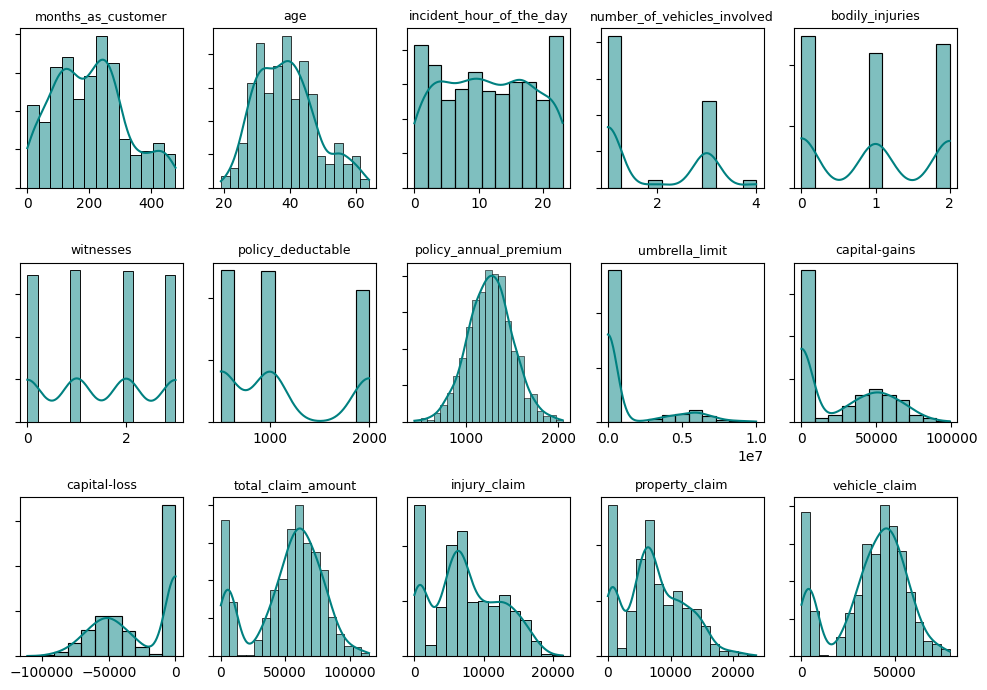

In [27]:
nrows = 3
ncols = 5

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10,7))

perm = list(product(range(nrows), range(ncols)))

for i, perm_i in enumerate(perm):
    col = num_features[i]
    row_idx = perm_i[0]
    col_idx = perm_i[1]

    sns.histplot(data = train_dataset, x = col, ax = ax[row_idx][col_idx], kde = True, color = 'teal')
    ax[row_idx][col_idx].set_yticklabels(labels = [])
    ax[row_idx][col_idx].set_ylabel(ylabel = None)
    ax[row_idx][col_idx].set_xlabel(xlabel = None)
    ax[row_idx][col_idx].set_title(label = col, size = 9)
    plt.tight_layout()

plt.show()

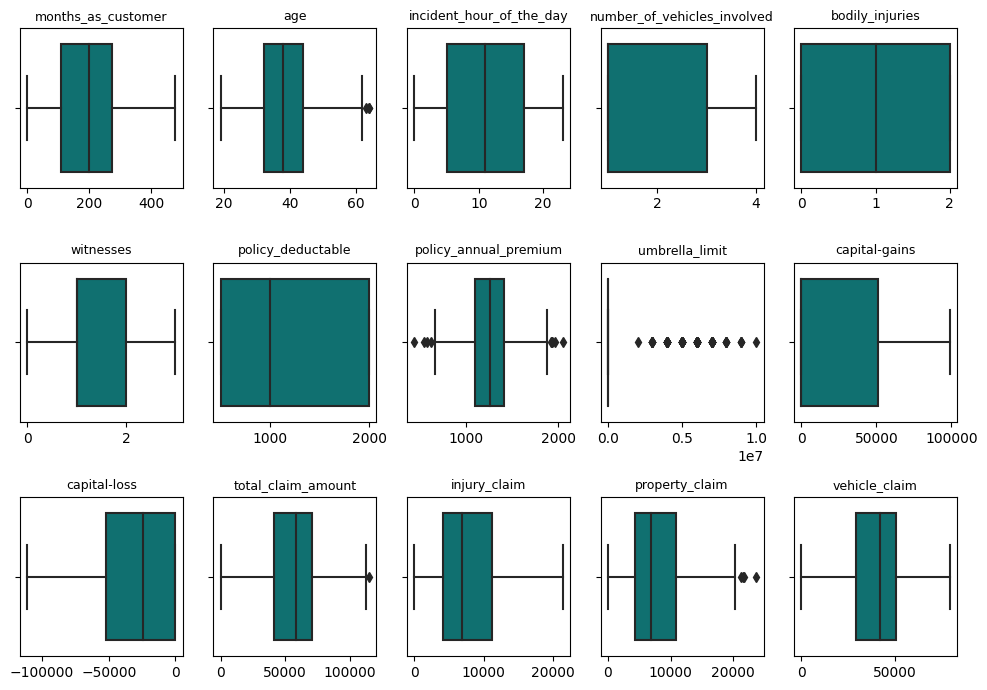

In [28]:
nrows = 3
ncols = 5

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10,7))

perm = list(product(range(nrows), range(ncols)))

for i, perm_i in enumerate(perm):
    col = num_features[i]
    row_idx = perm_i[0]
    col_idx = perm_i[1]

    sns.boxplot(data = train_dataset, x = col, ax = ax[row_idx][col_idx], color = 'teal')
    ax[row_idx][col_idx].set_yticklabels(labels = [])
    ax[row_idx][col_idx].set_ylabel(ylabel = None)
    ax[row_idx][col_idx].set_xlabel(xlabel = None)
    ax[row_idx][col_idx].set_title(label = col, size = 9)
    plt.tight_layout()

plt.show()

As visualized above, turns out almost all features are not normally distributed, except for the policy_annual_premium. And some features are discrete such as policy_deductible, number_of_vehicles_involved, bodily injuries, and witnesses, while the others are continuous.

Besides, some features also have outliers, but based on the boxplot, the most extreme outliers are in umbrella_limit. And based on the histogram, some features have a majority value in a specific bin, while the other values are normally distributed in the other bins. For this case, will look further.

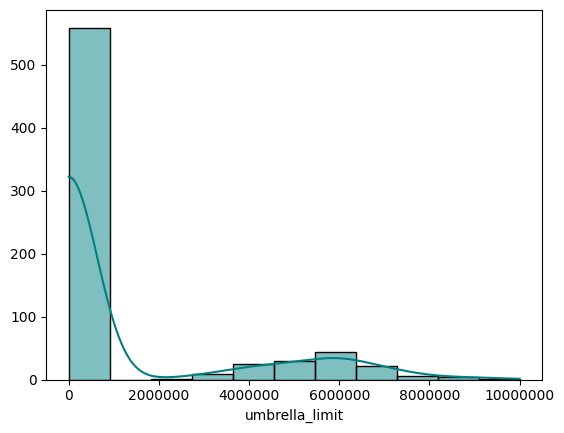

In [29]:
sns.histplot(train_dataset['umbrella_limit'], color = 'teal', kde = True).set(ylabel = None)
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

plt.show()

The most frequent value of umbrella_limit is around 0. Umbrella limit is the low-cost way to get significant extra liability coverage $^{1}$, which means it make sense that most people don't have umbrella_limit because it's just an extra coverage of main coverage insurance and just a few of them have the limit. So that, the outlier is valid and will left as it is.

------------------------------

$^{1}$ https://www.investopedia.com/articles/personal-finance/040115/how-umbrella-insurance-works.asp

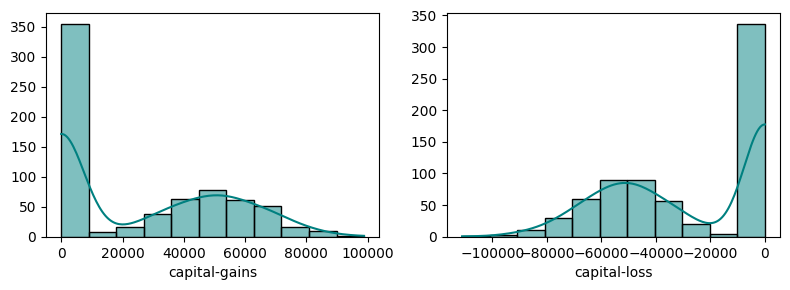

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,3))

sns.histplot(data = train_dataset, x = 'capital-gains', ax = ax[0], kde = True, color = 'teal')
ax[0].set_ylabel(ylabel = None)

sns.histplot(data = train_dataset, x = 'capital-loss', ax = ax[1], kde = True, color = 'teal')
ax[1].set_ylabel(ylabel = None)

plt.tight_layout()

plt.show()

Like umbrella_limit, capital-gains and capital-loss also have the most frequent values in 0, while the other values are normally distributed in the positive axis for capital-gains and negative axis for capital-loss.

Because of the data knowledge limitation, all of the outliers above will be left as it is.

***Categorical data***

In [31]:
vbar_data = [col for col in cat_features if len(train_dataset[col].unique()) <= 5 and col not in ['policy_number', 'insured_zip', 'incident_city', 'incident_location', 'incident_hour_of_the_day']]
hbar_data = [col for col in cat_features if len(train_dataset[col].unique()) > 5 and col not in ['policy_number', 'insured_zip', 'incident_city', 'incident_location', 'incident_hour_of_the_day']]

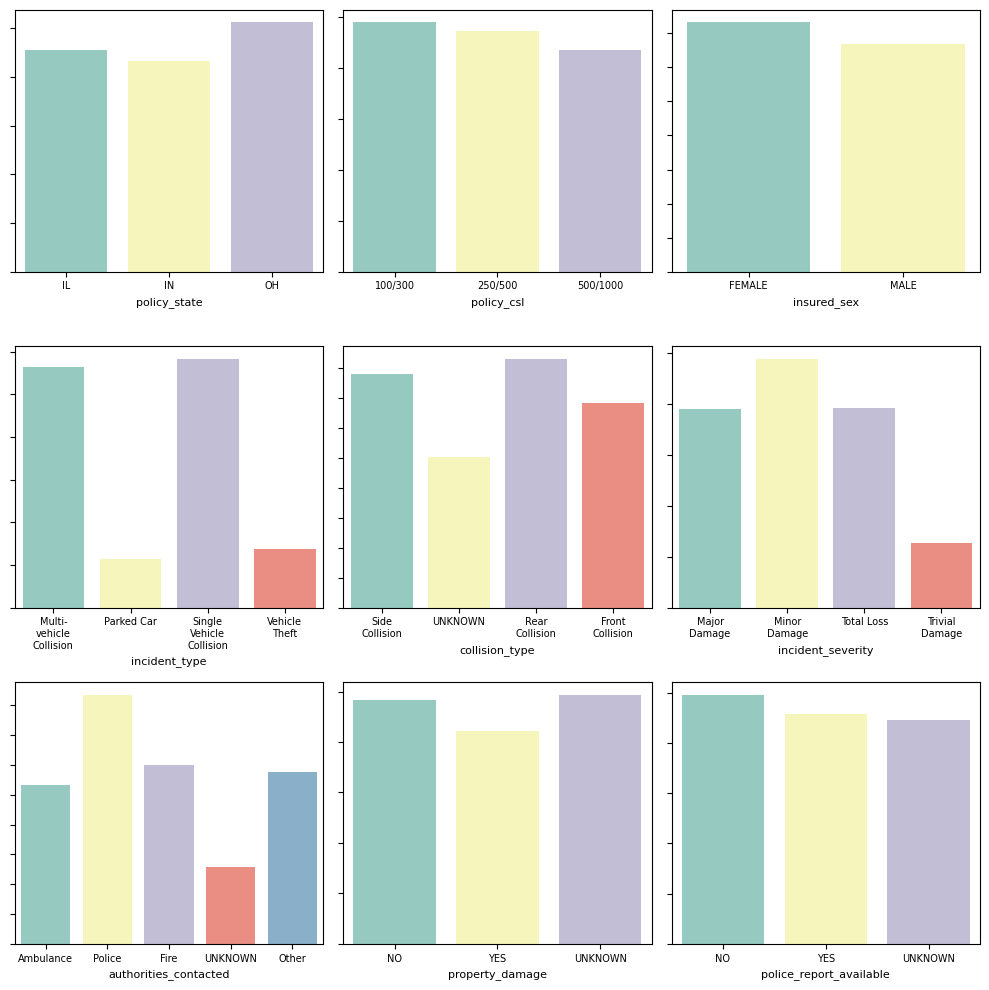

In [32]:
f = lambda x: fill(x.get_text(), 10)

nrows = 3
ncols = 3

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10,10))

perm = list(product(range(nrows), range(ncols)))

for i, perm_i in enumerate(perm):
    col = vbar_data[i]
    row_idx = perm_i[0]
    col_idx = perm_i[1]

    sns.countplot(data = train_dataset, x = col, palette=sns.color_palette('Set3'), ax = ax[row_idx][col_idx])
    ax[row_idx][col_idx].set_xticklabels(labels = map(f, ax[row_idx][col_idx].get_xticklabels()), fontsize = 7)
    ax[row_idx][col_idx].set_yticklabels(labels = [])
    ax[row_idx][col_idx].set_xlabel(xlabel = ax[row_idx][col_idx].get_xlabel(), fontsize = 8)
    ax[row_idx][col_idx].set_ylabel(ylabel = None)
    plt.tight_layout()

plt.show()

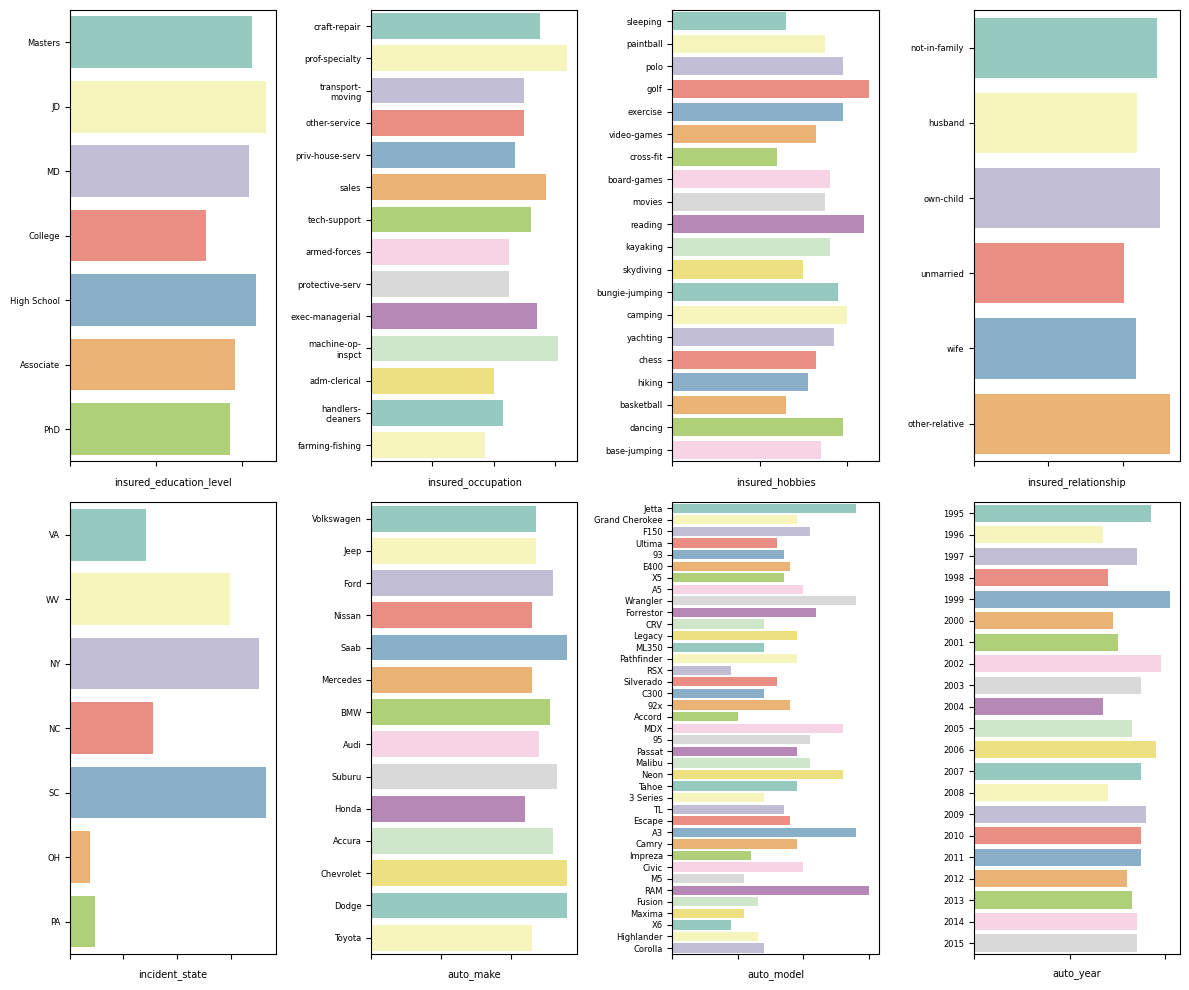

In [33]:
f = lambda x: fill(x.get_text(), 15)

nrows = 2
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12,10))

perm = list(product(range(nrows), range(ncols)))

for i, perm_i in enumerate(perm):
    col = hbar_data[i]
    row_idx = perm_i[0]
    col_idx = perm_i[1]

    sns.countplot(data = train_dataset, y = col, orient = 'h', palette=sns.color_palette('Set3'), ax = ax[row_idx][col_idx])
    ax[row_idx][col_idx].set_yticklabels(labels = map(f, ax[row_idx][col_idx].get_yticklabels()), fontsize = 6)
    ax[row_idx][col_idx].set_xticklabels(labels = [])
    ax[row_idx][col_idx].set_xlabel(xlabel = ax[row_idx][col_idx].get_ylabel(), fontsize = 7)
    ax[row_idx][col_idx].set_ylabel(ylabel = None)
    plt.tight_layout()

plt.show()

Most of the features have a similar distribution in their categories. Only a few features like incident_type, incident_severity, and incident state have most frequent in some categories than the others.

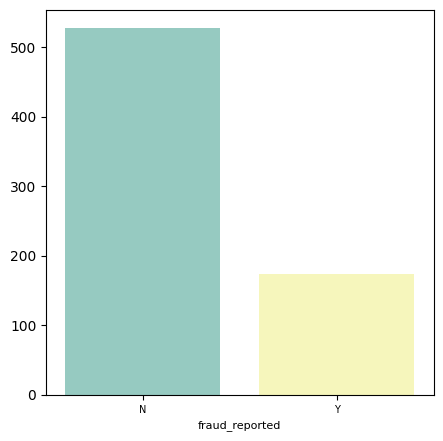

In [34]:
fig, ax = plt.subplots(figsize = (5,5))
sns.countplot(data = train_dataset, x = target, palette=sns.color_palette('Set3'))
ax.set_xticklabels(labels = map(f, ax.get_xticklabels()), fontsize = 7)
ax.set_xlabel(xlabel = ax.get_xlabel(), fontsize = 8)
ax.set_ylabel(ylabel = None)

plt.show()

But, the target label fraud_reported has imbalanced distribution, with the N label more than the Y label. This may be causing bias in predicting the label because the N label has more information than the Y. So, later the data will be re-sampling to handle this imbalance problem. Some re-sampling method that can be used:
1. Under-sampling using RandomUnderSampler
2. Over-samping using RandomOverSampler

**Bivariate Analysis**

**Correlation between numerical features**

In [35]:
# calculate correlation
corr = train_dataset[num_features].corr()

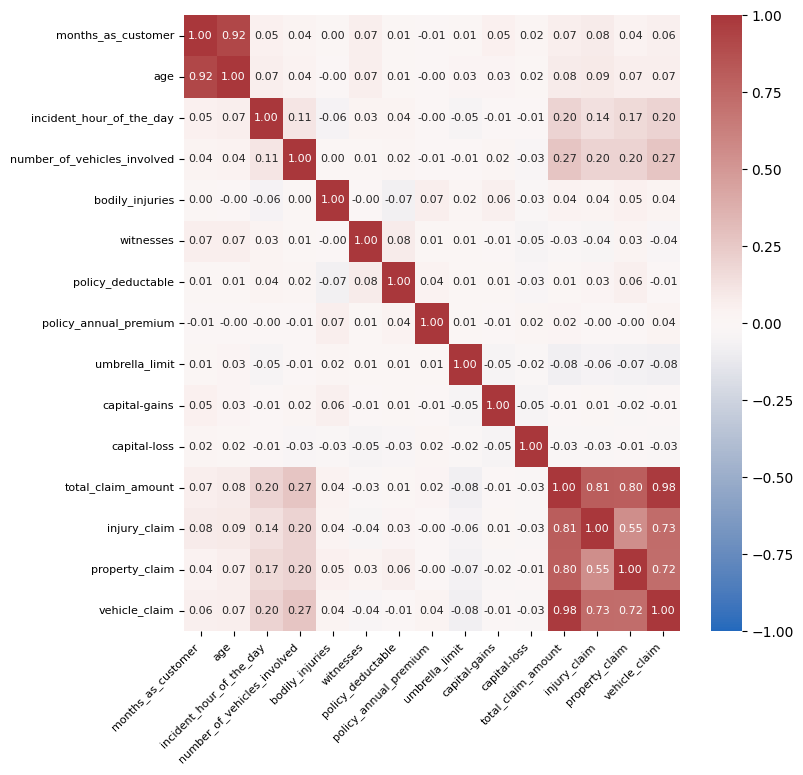

In [36]:
fig, ax = plt.subplots(figsize = (8,8))

sns.heatmap(data = corr, annot = True, fmt='.2f', annot_kws={'fontsize':8}, cmap = 'vlag', vmin = -1, vmax = 1)
ax.set_xticklabels(labels = ax.get_xticklabels(), fontsize = 8, rotation=45, horizontalalignment='right')
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 8)

plt.show()

In numerical features, there are some features that have a strong correlation such as month_as_customer with age, and all claim features (total_claim_amount, injury_claim, property_claim, vehicle_claim). Here's means the features are redundant, the value of one feature has been represented with the other feature. Including all redundant features is unnecessary for modelling.

The months_as_customer and age features have strong correlation so one of these features must be dropped.

So do total_claim_amount has been represented with injury_claim, property_claim, and vehicle_claim so this feature will not be used in modelling later. These 3 features are also quite correlated with each other, but will not be dropped because maybe these features have information to predict the label, but this thing can be causing multicollinearity.

**Correlation between categorical features**

Because the dimension of the dataset is quite high, the correlation only focuses on the label data. Using the Chi-square test will be tested is there any correlation between two categorical features.

With a confidence level of 95% (alpha = 0.05), here's the hypothesis:

H0: There is no correlation between two features<br>
H1: There is a correlation between two features

In [37]:
chisq_matrix = pd.DataFrame(columns = cat_features + [target],
                            index = cat_features)

In [38]:
for row in cat_features:
    for col in cat_features + [target]:
        cross_tab = pd.crosstab(columns = train_dataset[row], index = train_dataset[col])
        chisq_value = chi2_contingency(cross_tab)[1]
        if cross_tab.min().min() < 5:
            chisq_matrix.loc[row, col] = None
        else:
            chisq_matrix.loc[row, col] = chisq_value

chisq_matrix = pd.DataFrame(chisq_matrix.loc[:,target]).rename(columns = {target: target + ' (p_value)'})
chisq_matrix

,fraud_reported (p_value)
policy_number,None
policy_state,0.59
policy_csl,0.25
insured_zip,None
insured_sex,0.22
insured_education_level,0.87
insured_occupation,0.05
insured_hobbies,None
insured_relationship,0.26
incident_type,0.00


The chi-square test will provide evidence either in favor of or against the statistical independence of two variables, but it won't give any information about the strength or direction of the relationship $^2$. Knowing the correlation between two features (the input) has nothing to do without knowing the strength of the correlation, so here only focused on label data to see which features have a correlation with the label.

Above is p-value for every categorical feature to fraud_reported. For level significance 95% (alpha 0.05), H0 is rejected if the p-value < 0.05 means there is a correlation between two variables. In this case, features that correlated with fraud_reported are incident_type and collision_type. 

For the other features with None value is not required chi-square test assumption, that says every cell in the cross tab must be greater or equal to 5. $^3$ So, for these features do not known how the correlation is with fraud_reported.

-----------------

$^2$ https://soc.utah.edu/sociology3112/chi-square.php#:~:text=If%20two%20variables%20are%20correlated,that%20between%20two%20nominal%20variables.

$^3$ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900058/

**Correlation between categorical and numerical features**

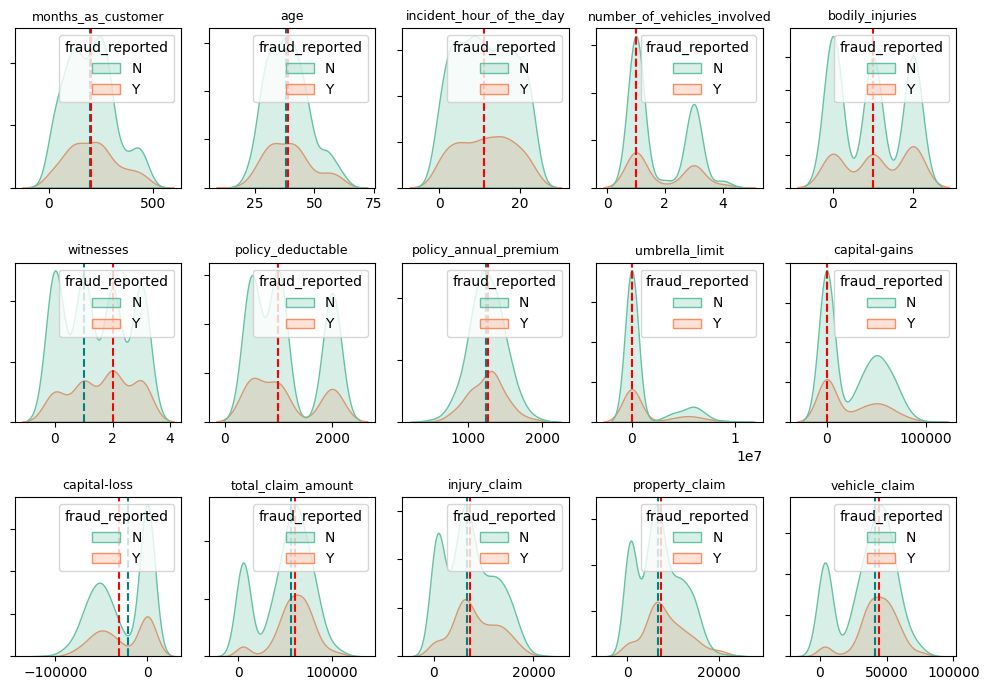

In [39]:
nrows = 3
ncols = 5

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (10,7))

perm = list(product(range(nrows), range(ncols)))

for i, perm_i in enumerate(perm):
    col = num_features[i]
    row_idx = perm_i[0]
    col_idx = perm_i[1]
    
    sns.kdeplot(data = train_dataset, x = col, hue = target, 
                ax = ax[row_idx][col_idx], fill = True, legend = True, palette = 'Set2')
    
    mean_X = np.median(train_dataset[train_dataset[target] == 'N'][col])
    ax[row_idx][col_idx].axvline(mean_X, color='teal', linestyle = '--')

    mean_Y = np.median(train_dataset[train_dataset[target] == 'Y'][col])
    ax[row_idx][col_idx].axvline(mean_Y, color='red', linestyle = '--')

    ax[row_idx][col_idx].set_yticklabels(labels = [])
    ax[row_idx][col_idx].set_xlabel(ax[row_idx][col_idx].get_xlabel(), fontsize = 7)
    ax[row_idx][col_idx].set_xlabel(xlabel = None)
    ax[row_idx][col_idx].set_ylabel(ylabel = None)
    ax[row_idx][col_idx].set_title(label = col, size = 9)

    plt.tight_layout()

plt.show()

Overall, the distribution of numerical features group by fraud_reported is quite similar for the two groups N and Y. Because the feature's distribution is mostly not normally distributed, then here's used median for the statistics measurement. The median for the two groups is quite similar for all features, even some features have an overlapping median for the group N and Y.

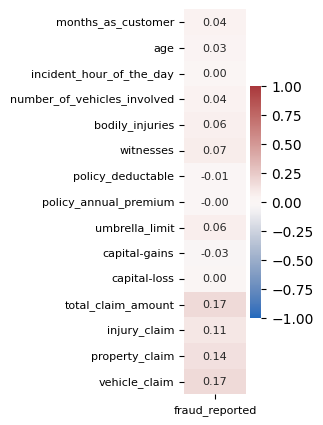

In [40]:
train_dataset['fraud_reported_dummy'] = pd.get_dummies(train_dataset[target], dtype=int)['Y']
corr = train_dataset[num_features + ['fraud_reported_dummy']].corr().drop(['fraud_reported_dummy'], axis = 0)

fig, ax = plt.subplots(figsize = (1,5))

sns.heatmap(data = corr[['fraud_reported_dummy']], annot = True, fmt='.2f', annot_kws={'fontsize':8}, cmap = 'vlag', vmin = -1, vmax = 1)
ax.set_xticklabels(labels = ['fraud_reported'], fontsize = 8, rotation=0, horizontalalignment='center')
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 8)

plt.show()

But, based on the correlation, there's no feature that have correlation with fraud_reported.

By this information, fraud_reported has no linear correlation with any categorical and numerical features, so Logistic Regression is not suitable for this data. So does K-Nearest Neighbor because the high dimensionality will not perform well with this data and need dimensionality reduction in the data.

Hence, in this case, will use the tree-based model to predict the target.

**Summary and what to do in the next process:**
1. Drop some features required below:
   * Intuitively irrelevant to the label data and model ('policy_number', 'policy_bind_date', 'insured_zip', 'incident_date', 'incident_city', 'incident_location', 'incident_hour_of_the_day')
   * For features that have strong correlation drop one of those ('months_as_customer', 'total_claim_amount')
2. Fixing data type to make sure the data type is suitable
3. Do imputation to categorical features with value '?' to 'UNKNOWN'
4. Do not scaling numerical features because tree based model not required feature scaling
5. Labeling categorical features using One Hot Encoder
6. Re-sampling to balancing label data with methods:
   * Under-sampling using RandomUnderSampler
   * Over-samping using RandomOverSampler
7. Modelling with tree based methods:
   * Decision Tree
   * Random Forrest
   * Adaboost
   * Gradient Boost
   * XGB
8. Because of imbalanced data, the objective is aiming for the high F1-score and Precision-Recall Score